
# Data

This project utilizes data from the [Comparative Manifesto Project (CMP)](https://manifesto-project.wzb.eu/), which provides political manifestos annotated at the quasi-sentence level. These annotations include manually assigned policy codes corresponding to predefined political topics. The objective of this project is to use the text content of these quasi-sentences—without labels—to cluster them into coherent topic groups resembling the CMP’s main categories.


## Data Source and Access
The data is accessed programmatically via the CMP’s official REST API. An API key is used for authenticated requests. Using a series of endpoint queries, the following resources were retrieved:

- **Core dataset metadata** (party, country, date, etc.)
- **Manifesto metadata** to filter for English translations and machine-readable annotations
- **Full quasi-sentence text** and their respective structure for selected manifestos

Data retrieval is restricted to manifestos from Germany, Switzerland, and Austria, where English translations and machine-annotated versions are available.

## Manifesto Selection Criteria
From the full list of manifestos, only a subset was selected based on the following conditions:

1. Country must be Germany, Switzerland, or Austria
2. Manifesto must have an English translation (`translation_en = True`)
3. Manifesto must include sentence-level annotations (`annotations = True`)
4. Only the latest manifesto per party is kept to avoid duplication and ensure contemporary relevance

In [1]:
def get_manifestos_from_api():

    import requests
    import pandas as pd

    # Load API key
    with open('manifesto_apikey.txt', 'r') as file:
        API_KEY = file.read().strip()

    BASE_URL = 'https://manifesto-project.wzb.eu/api/v1/'

    # --- 1. Get Latest Core Dataset ---
    ENDPOINT = 'get_core'
    params = {
        'api_key': API_KEY,
        'key': 'MPDS2024a'
    }

    response = requests.get(BASE_URL + ENDPOINT, params=params)

    if response.status_code == 200:
        data = response.json()
        df = pd.DataFrame(data)
        print(f"Retrieved {len(df)} rows in core dataset.")
    else:
        print(f"Failed to fetch core data. Status code: {response.status_code}")
        print(response.text)
        exit()

    # --- 2. Filter latest manifestos for selected countries ---
    countrynames = ["Switzerland", "Germany", "Austria"]
    df.columns = [str(col) for col in df.columns]

    # 1 = countryname, 5 = date, 6 = party abbreviation
    filtered_df = df[df['1'].isin(countrynames)]
    latest_manifestos = filtered_df.sort_values('5').groupby('6', as_index=False).last()

    manifesto_ids = [f"{row['6']}_{row['5']}" for _, row in latest_manifestos.iterrows()]
    print(f'Found {len(manifesto_ids)} latest manifesto IDs.')

    # --- 3. Get Metadata and Filter for Machine-Readable English Texts ---
    ENDPOINT = 'metadata'
    params = {
        'api_key': API_KEY,
        'keys[]': manifesto_ids,
        'version': '2024-1'
    }

    response = requests.get(BASE_URL + ENDPOINT, params=params)
    manifesto_ids = []  # reset this with machine-readable ones

    if response.status_code == 200:
        data = response.json()
        for item in data['items']:
            if item.get('annotations') and item.get('translation_en'):
                manifesto_ids.append(item['manifesto_id'])
        print(f'Found {len(manifesto_ids)} machine-readable manifesto IDs.')
    else:
        print(f"Failed to fetch metadata. Status code: {response.status_code}")
        print(response.text)
        exit()

    # --- 4. Fetch Texts and Annotations for Final List ---
    ENDPOINT = 'texts_and_annotations'
    params = {
        'api_key': API_KEY,
        'keys[]': manifesto_ids,
        'version': '2024-1',
        'translation': 'en'
    }

    response = requests.get(BASE_URL + ENDPOINT, params=params)

    if response.status_code == 200:
        data = response.json()
        df = pd.DataFrame(data['items'])
        print(f"Retrieved {len(df)} manifestos with annotated text.")
        return df

    else:
        print(f"Failed to fetch texts and annotations. Status code: {response.status_code}")
        print(response.text)
        exit()

In [2]:
# Get Data from file or from source

import pickle
import os

os.makedirs("cache_files", exist_ok=True)
filename = "cache_files/cached_manifestos.pkl"

# Laden, wenn vorhanden
if os.path.exists(filename):
    with open(filename, 'rb') as f:
        df = pickle.load(f)
    print("Daten aus Cache geladen.")
else:
    # Dein teurer API-Call oder Verarbeitung
    df = get_manifestos_from_api()

    # Zwischenspeichern
    with open(filename, 'wb') as f:
        pickle.dump(df, f)
    print("Daten gespeichert.")

Daten aus Cache geladen.


## Quasi-Sentence Extraction
The text content of each manifesto is returned as a list of quasi-sentences—units of meaning used by CMP to annotate policy content. These were extracted and aggregated into a dictionary of the form:

```python
{
    "manifesto_id_1": [
        {"text": "qs1", "cmp_code": 101},
        {"text": "qs2", "cmp_code": 204},
        {"text": "qs3", "cmp_code": 503},
        # ...
    ],
    "manifesto_id_2": [
        {"text": "qs1", "cmp_code": 402},
        {"text": "qs2", "cmp_code": 302},
        # ...
    ],
    # ...
}
```

In [3]:
# Define the CMP code to category mapping
cmp_category_mapping = {
    '1': 'External Relations',
    '2': 'Freedom and Democracy',
    '3': 'Political System',
    '4': 'Economy',
    '5': 'Welfare and Quality of Life',
    '6': 'Fabric of Society',
    '7': 'Social Groups'
}

# Helper function to get category from CMP code
def get_category(cmp_code):
    try:
        code_str = str(cmp_code).strip()
        if not code_str or code_str == 'NA':
            return 'Uncategorized'
        return cmp_category_mapping.get(code_str[0], 'Uncategorized')
    except Exception:
        return 'Uncategorized'

# Build the structured manifesto data
manifestos = {}

In [4]:
for i, row in df.iterrows():
    manifesto_items = []
    manifesto_id = row['key']
    
    for item in row['items']:
        cmp_code = item.get('cmp_code', 'NA')
        if cmp_code == 'NA':
            continue
        
        category = get_category(cmp_code)
        if category == 'Uncategorized':
            continue
        
        manifesto_items.append({
            "text": item['text'],
            "cmp_code": cmp_code,
            "category": category
        })
    
    manifestos[manifesto_id] = manifesto_items

## Category Mapping

lthough this is an unsupervised task, the CMP codebook was downloaded and consulted to define reference categories for qualitative evaluation. The seven CMP "main domains" used as reference topics are:

1. External Relations
2. Freedom and Democracy
3. Political System
4. Economy
5. Welfare and Quality of Life
6. Fabric of Society
7. Social Groups

These categories serve as a qualitative benchmark to interpret the discovered clusters. While these are not used directly in training or clustering, several hand-coded samples are referenced for evaluation in Section 4.

The resulting dataframe looks like this:


| manifesto_id | text                     | cmp_code | category              |
|--------------|--------------------------|----------|------------------------|
| GER_202109   | "We support..."          | 403      | Economy                |
| GER_202109   | "Democracy is essential" | 201      | Freedom and Democracy  |


In [5]:
import pandas as pd

# Flatten manifestos dict into rows
rows = []

for manifesto_id, items in manifestos.items():
    for item in items:
        rows.append({
            "manifesto_id": manifesto_id,
            "text": item["text"],
            "cmp_code": item["cmp_code"],
            "category": item["category"]
        })

# Create DataFrame
manifestos_df = pd.DataFrame(rows)

## Data Exploration

First, I explore the Data in the form described previously to get an idea if it is ready for clustering or if it needs pore preprocessing.

In [6]:
# 1. Basic Statistisc
print(f"Number of quasi-sentences: {len(manifestos_df)}")
print(f"Number of unique manifestos: {manifestos_df['manifesto_id'].nunique()}")
print(f"Number of unique categories: {manifestos_df['category'].nunique()}")

Number of quasi-sentences: 36088
Number of unique manifestos: 34
Number of unique categories: 7


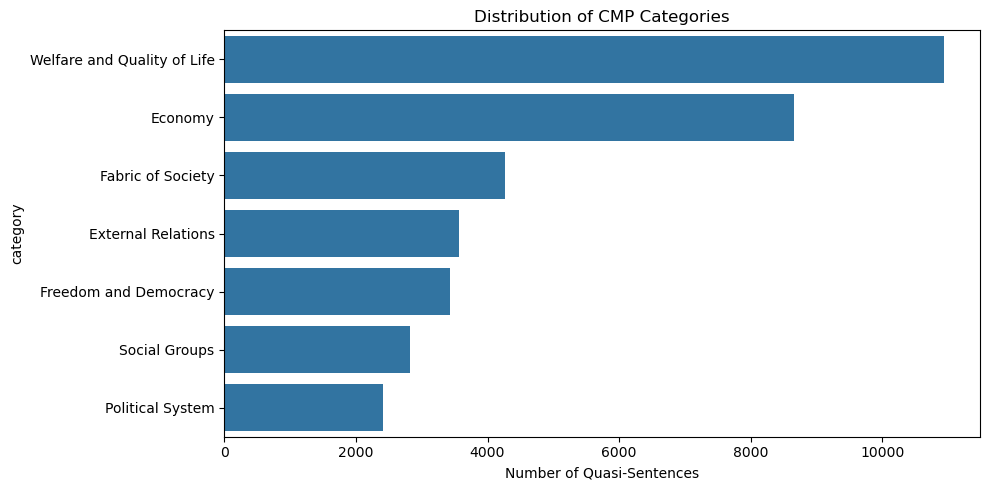

In [7]:
# 2. Category Distribution
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.countplot(data=manifestos_df, y="category", order=manifestos_df["category"].value_counts().index)
plt.title("Distribution of CMP Categories")
plt.xlabel("Number of Quasi-Sentences")
plt.tight_layout()
plt.show()

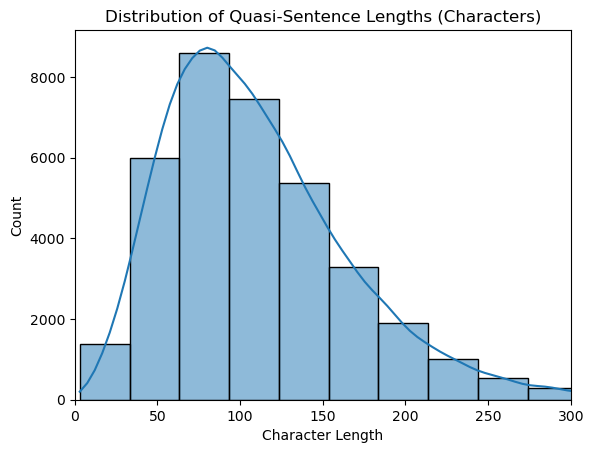

In [8]:
# 3. Sentence Length Distribution
# Character Level
manifestos_df["char_len"] = manifestos_df["text"].str.len()

sns.histplot(manifestos_df["char_len"], bins=30, kde=True)
plt.title("Distribution of Quasi-Sentence Lengths (Characters)")
plt.xlabel("Character Length")
ax = plt.gca()
ax.set_xlim([0, 300])
plt.show()

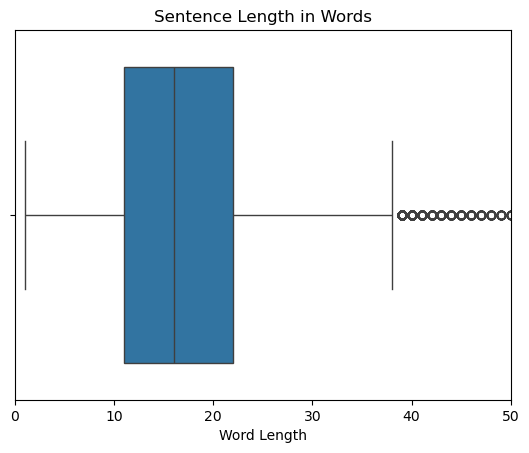

In [9]:
# 3.1 Token Level
manifestos_df["word_count"] = manifestos_df["text"].str.split().str.len()

sns.boxplot(data=manifestos_df, x="word_count")
plt.title("Sentence Length in Words")
plt.xlabel("Word Length")
ax = plt.gca()
ax.set_xlim([0, 50])
plt.show()

To get an idea about the content of the categories, I take a look at the most frequent words. Here I take the example of Economy.

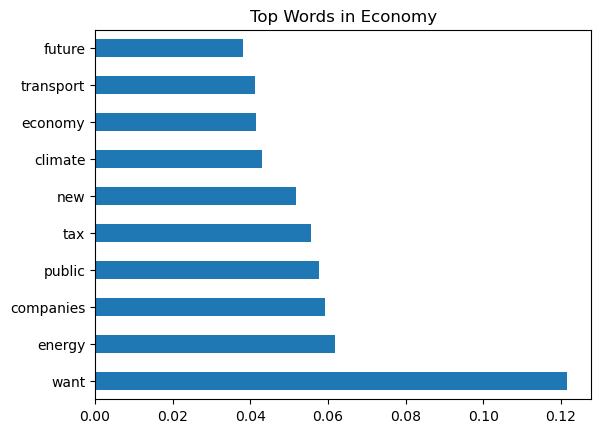

In [10]:
# Word Frequencies per Category
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(stop_words='english', max_features=5000)
X_counts = vectorizer.fit_transform(manifestos_df["text"])

# Add category column to sparse matrix
counts_df = pd.DataFrame(X_counts.toarray(), columns=vectorizer.get_feature_names_out())
counts_df["category"] = manifestos_df["category"]

# Average word frequencies per category
top_words = counts_df.groupby("category").mean().T

category = cmp_category_mapping['4'] # choose category of interest

top_words[category].sort_values(ascending=False).head(10).plot(kind="barh")
plt.title(f'Top Words in {category}')
plt.show()

## Grouping Sentences
In the Data Exploration Step I realized that the length of the Quasi-Sentences would be a problem. The average length is only about fifteen words which makes the Clustering Task very difficult until almost impossible. For this reason the Quasi-Sentences are grouped to perform the Machine Learning Task as Follows.

| manifesto_id | text                     | cmp_code | category              |sentence_group  |
|--------------|--------------------------|----------|------------------------|---------------|
| GER_202109   | "We support..."          | 403.1      | Economy                |  1   |
| GER_202109   | "...are taxes..."        | 403.2      | Economy             |   1   |
| GER_202109   | "Democracy is essential" | 201      | Freedom and Democracy  |  2   |

After Grouping, the distribution of Character Lengths is checked again. The longer text length should make the Dimensionality Reduction and Clustering easier.

Each quasi-sentence group was then prepared for embedding using a sentence-transformer model in the next stage of the pipeline (described in Section 3).

In [11]:
import pandas as pd

# Stelle sicher, dass der DataFrame korrekt sortiert ist
df = manifestos_df.sort_values(by=['manifesto_id', 'category']).reset_index(drop=True)

# Hilfsspalte: wenn sich manifesto_id oder category ändern, beginnt eine neue Gruppe
group_change = (
    (df['manifesto_id'] != df['manifesto_id'].shift()) |
    (df['category'] != df['category'].shift())
).cumsum()

# Füge sentence_group-Spalte hinzu
df['sentence_group'] = group_change

# Gruppieren und Texte zusammenführen
grouped_df = (
    df.groupby(['manifesto_id', 'category', 'sentence_group'], as_index=False)
    .agg({'text': ' '.join})
)

# Nur relevante Spalten behalten
grouped_df = grouped_df[['manifesto_id', 'category', 'text']]

# Ergebnis anzeigen
print(grouped_df.head())

# Export als CSV
grouped_df.to_csv("df_manifestos_grouped_sentences.csv", index=False)

   manifesto_id               category  \
0  41113_202109                Economy   
1  41113_202109     External Relations   
2  41113_202109      Fabric of Society   
3  41113_202109  Freedom and Democracy   
4  41113_202109       Political System   

                                                text  
0  Through science and progress. We have seen how...  
1  We have learned how limited national answers t...  
2  It has shown in a good way the commonality, in...  
3  Dear voters, it is through elections that a so...  
4  We, BÜNDNIS 90/DIE GRÜNEN, are presenting our ...  


## Data Exploration of Sentence Groups

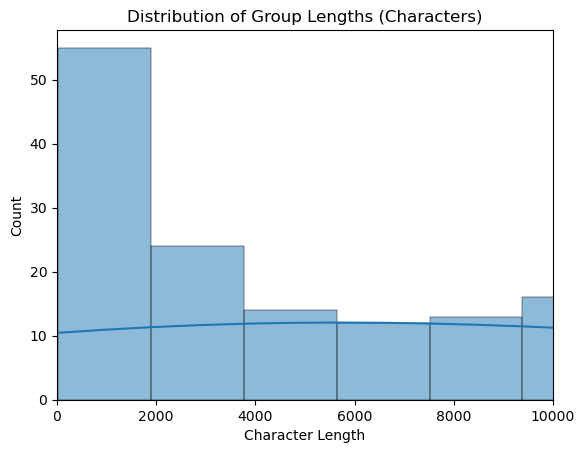

In [12]:
# Sentence Length Distribution
# Character Level
grouped_df["char_len"] = grouped_df["text"].str.len()

sns.histplot(grouped_df["char_len"], bins=100, kde=True)
plt.title("Distribution of Group Lengths (Characters)")
plt.xlabel("Character Length")
ax = plt.gca()
ax.set_xlim([0, 10000])
plt.show()

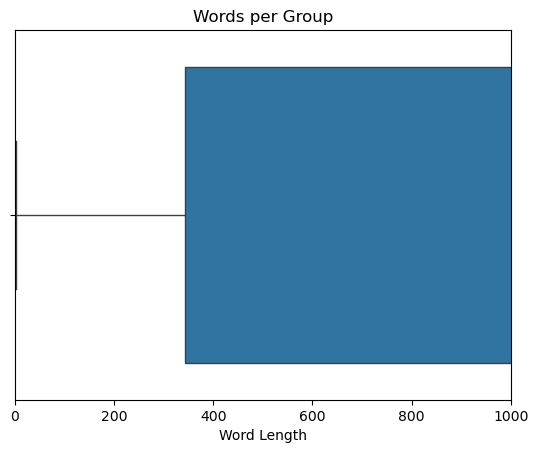

In [13]:
# Token (Sentence) Level
grouped_df["word_count"] = grouped_df["text"].str.split().str.len()

sns.boxplot(data=grouped_df, x="word_count")
plt.title("Words per Group")
plt.xlabel("Word Length")
ax = plt.gca()
ax.set_xlim([0, 1000])
plt.show()

# Methods

The central aim of this project is to cluster quasi-sentences from political manifestos into coherent topic groups, ideally resembling the seven high-level categories defined by the Comparative Manifesto Project (CMP). Since no sentence-level topic labels are used during model training, the task is unsupervised in nature.

This section describes and motivates the methods used at each stage: transforming raw text into a numerical representation, reducing dimensionality for visualization and noise reduction, and applying clustering algorithms to identify topic-like groupings. Special attention is given to the suitability of each technique for short political text fragments and the challenges inherent to topic modeling without supervision.

## Sentence Embedding

Quasi-sentences from manifestos are typically short—often no more than a clause or single policy statement. To represent these as inputs for clustering, the project uses *sentence embeddings*, which map each sentence to a fixed-length vector in a high-dimensional space.

The selected model is **Sentence-BERT (SBERT)**, a transformer-based architecture specifically designed for semantically meaningful sentence embeddings. Unlike vanilla BERT, which isn't optimized for sentence-level similarity, SBERT introduces a siamese network structure that enables efficient semantic similarity computation. The pre-trained model `all-MiniLM-L6-v2` was chosen for its balance between performance and speed.

Sentence embeddings are preferred over traditional bag-of-words or TF-IDF vectors for several reasons:

- They capture **semantic similarity**, not just token overlap.
- They produce **fixed-size dense vectors**, suitable for distance-based clustering.
- They perform well on short, syntactically diverse texts such as political quasi-sentences.

Each quasi-sentence is thus encoded into a 384-dimensional vector, which serves as the input to subsequent analysis.

## Dimensionality Reduction

Before applying clustering algorithms, the embedding space is optionally reduced to a lower dimension to address two issues:

- **Curse of dimensionality**: In high-dimensional spaces, distance metrics become less meaningful, which can degrade clustering performance.
- **Visualization**: Human interpretation of cluster structure requires 2D or 3D projections.

The method of choice is **Principal Component Analysis (PCA)**. PCA projects the data onto a lower-dimensional orthogonal subspace that captures as much variance as possible. In this project, PCA is used primarily for:

- Reducing noise in the input to clustering
- Projecting cluster centroids for manual inspection
- Identifying dominant axes of variation across quasi-sentences (e.g., economy vs. welfare focus)

PCA is chosen over nonlinear methods such as t-SNE or UMAP because:

- It is **deterministic** and interpretable.
- It preserves **global structure** better, which is useful for clustering.
- It enables visualization of loadings (important features) via **biplots**.

## Clustering Algorithms

### K-Means Clustering

The first method applied is **k-means clustering**, a centroid-based algorithm that partitions the data into *k* clusters by minimizing intra-cluster variance. The objective function is:

$$
\underset{C}{\text{argmin}} \sum_{i=1}^{k} \sum_{\mathbf{x}_j \in C_i} \|\mathbf{x}_j - \boldsymbol{\mu}_i\|^2
$$

where $\boldsymbol{\mu}_i$ is the centroid of cluster $C_1$.

K-means is a natural choice because:

- It scales efficiently to large datasets.
- It provides **hard assignments** (each sentence belongs to exactly one cluster).
- It requires minimal assumptions about data distribution.

However, k-means has notable limitations:

- It assumes **spherical clusters of similar size**, which may not hold for natural language data.
- It is sensitive to initialization and the chosen number of clusters *k*.

To mitigate this, the **elbow method** and **silhouette scores** are used to identify a suitable value for *k*, with *k = 7* being a theoretically motivated target corresponding to the CMP categories.

### Hierarchical Agglomerative Clustering

To complement k-means, **hierarchical agglomerative clustering (HAC)** is applied. HAC recursively merges the most similar clusters based on a linkage criterion until all data points are grouped into one hierarchy (a dendrogram). The project uses **Ward's method**, which minimizes the increase in total within-cluster variance when merging clusters.

HAC offers several advantages in this context:

- It does not require pre-specifying the number of clusters.
- It can reveal **nested structure**, which is conceptually useful since some CMP topics (e.g., Economy and Welfare) may be subtopics of broader ideological themes.
- It provides a visual dendrogram, which helps in interpreting inter-topic relationships.

HAC is particularly suitable for this task due to the lack of strong assumptions about cluster shape and the ability to **explore multiple granularities** of topic clusters by cutting the dendrogram at different heights.

### Evaluation Metrics

Since this is an unsupervised task, standard accuracy metrics are not applicable. Instead, clustering quality is evaluated using:

- **Silhouette Score**: Measures how well-separated the clusters are.
- **Intra-cluster vs. Inter-cluster Distances**: Helps evaluate cohesion and separation.
- **Qualitative Inspection**: The top sentences closest to each cluster centroid are examined for thematic coherence and alignment with CMP macro categories.

If partial labeled data is available (e.g., from hand-coded samples), **Adjusted Rand Index (ARI)** or **Normalized Mutual Information (NMI)** may also be computed for external validation.

---

The combination of SBERT for semantic representation, PCA for structure reduction, and both k-means and hierarchical clustering for discovery provides a robust pipeline for the unsupervised categorization of manifesto text. Each method was selected to balance interpretability, computational feasibility, and alignment with the nature of political language data.

# Implementation and Results

This section describes the practical application of the methods to the manifesto quasi-sentences. The steps include generating sentence embeddings, reducing dimensionality for structure and visualization, applying clustering algorithms, and evaluating clustering performance. Finally, the resulting clusters are analyzed to address the political research question: **Do socialist parties emphasize welfare and quality of life more often than right-wing populist parties?**

## Sentence Embedding

To convert each quasi-sentence in `manifestos_df["text"]` into a numerical vector, we use the pre-trained `all-MiniLM-L6-v2` Sentence-BERT model. Each sentence is encoded into a 384-dimensional vector capturing semantic similarity.

In [14]:
def get_embeddings():

    from sentence_transformers import SentenceTransformer

    model = SentenceTransformer('all-MiniLM-L6-v2')
    embeddings = model.encode(df["text"].tolist(), show_progress_bar=True)

    return embeddings

In [15]:
import pickle
import os

filename = "cache_files/cached_embeddings.pkl"

if os.path.exists(filename):
    with open(filename, 'rb') as f:
        embeddings = pickle.load(f)
    print("Daten aus Cache geladen.")
else:
    embeddings = get_embeddings()
    with open(filename, 'wb') as f:
        pickle.dump(embeddings, f)
    print("Daten gespeichert.")


Batches:   0%|          | 0/1128 [00:00<?, ?it/s]

Daten gespeichert.


In [16]:
import numpy as np

# Convert to numpy array for further processing
X = np.array(embeddings)

A few example embeddings:

In [17]:
pd.DataFrame(X[:3], columns=[f"dim_{i}" for i in range(X.shape[1])])

,dim_0,dim_1,dim_2,dim_3,dim_4,dim_5,dim_6,dim_7,dim_8,dim_9,...,dim_374,dim_375,dim_376,dim_377,dim_378,dim_379,dim_380,dim_381,dim_382,dim_383
0,0.020657,-0.010217,0.013811,0.011986,0.011888,0.000365,-0.039776,-0.029985,-0.013995,0.045425,...,-0.068132,-0.043922,-0.019399,-0.041941,-0.020816,0.058044,0.075349,-0.063794,0.104120,0.015725
1,0.030968,-0.047497,-0.054813,-0.012154,0.077466,0.004317,-0.063012,0.071940,-0.084385,-0.021622,...,0.021416,-0.047563,0.005488,0.070395,-0.090356,-0.018626,0.032812,-0.057583,0.114151,0.086400
2,0.104659,-0.061780,0.027408,0.065094,0.054538,-0.057555,0.000832,0.048637,0.057563,-0.025595,...,0.041866,-0.022750,0.050305,-0.061264,-0.096754,0.029255,0.088028,0.017394,-0.105544,-0.011518


These vectors serve as the input to both the dimensionality reduction and clustering steps.

## Dimensionality Reduction

To visualize the sentence embeddings and reduce potential noise, we apply **Principal Component Analysis (PCA)** to project the high-dimensional space into two dimensions.

PCA-Embedding berechnet und gespeichert.


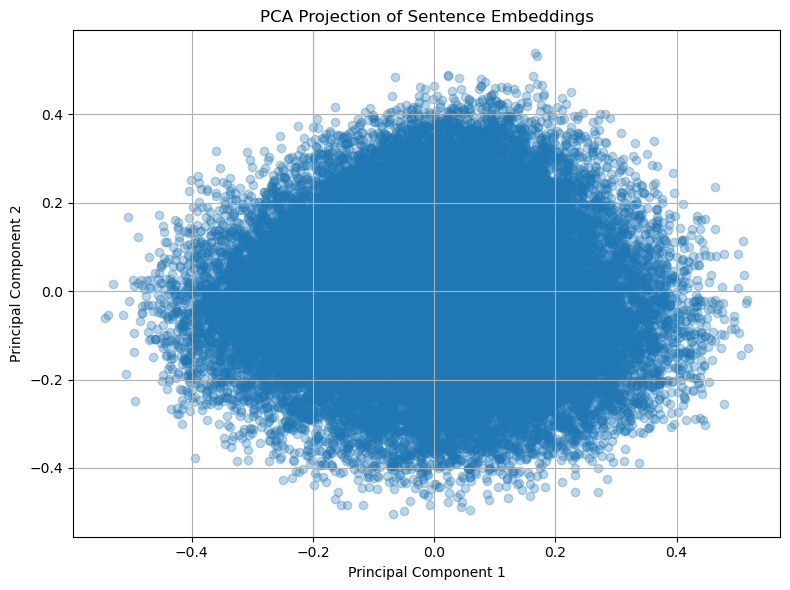

In [18]:
import os
import pickle
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Pfad zum Cache
pca_cache_path = "cache_files/cached_pca.pkl"

# Versuche PCA-Ergebnisse zu laden
if os.path.exists(pca_cache_path):
    with open(pca_cache_path, "rb") as f:
        X_pca = pickle.load(f)
    print("PCA-Embedding aus Cache geladen.")
else:
    # Führe PCA durch
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)
    
    # Speichern
    with open(pca_cache_path, "wb") as f:
        pickle.dump(X_pca, f)
    print("PCA-Embedding berechnet und gespeichert.")

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.3)
plt.title("PCA Projection of Sentence Embeddings")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.tight_layout()
plt.show()


To understand how the PCA dimensions relate to the underlying CMP topics, we can color the points by the manually annotated categories.

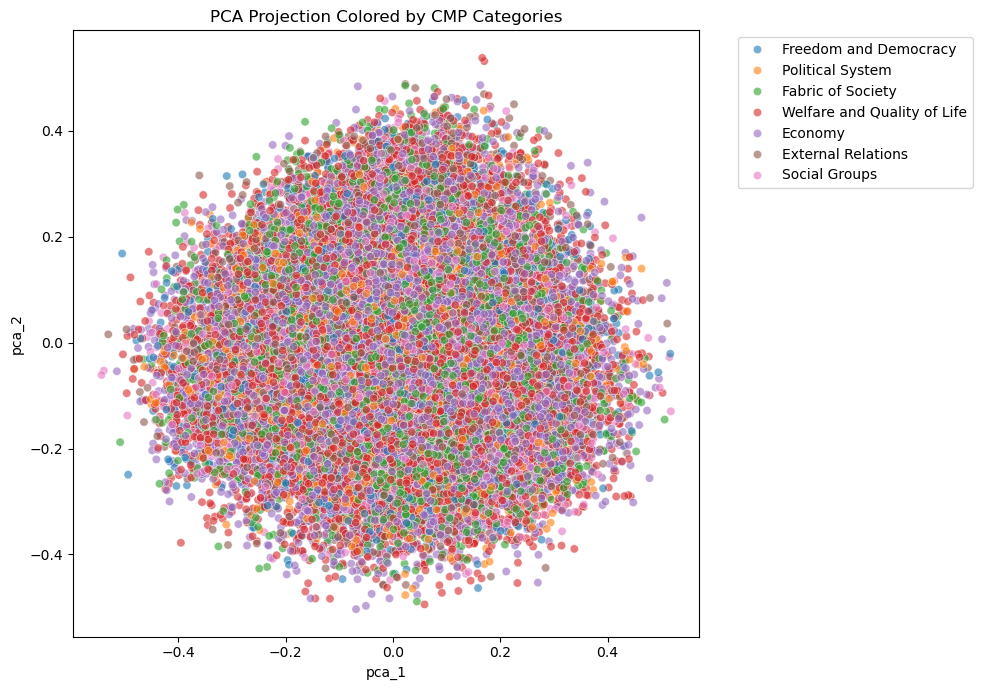

In [19]:
import seaborn as sns

manifestos_df["pca_1"] = X_pca[:, 0]
manifestos_df["pca_2"] = X_pca[:, 1]

plt.figure(figsize=(10, 7))
sns.scatterplot(data=manifestos_df, x="pca_1", y="pca_2", hue="category", palette="tab10", alpha=0.6)
plt.title("PCA Projection Colored by CMP Categories")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

The visualization shows some topic separation, although there is noticeable overlap — expected given the complexity and brevity of the quasi-sentences.

## Clustering and Evaluation

We apply two clustering algorithms: **k-means** and **hierarchical agglomerative clustering** (Ward linkage). Since we are working toward seven CMP topics, we set the number of clusters to `k = 7`.

### K-Means Clustering

Evaluate clustering using Adjusted Rand Index (ARI), which measures similarity between the clustering and the known `category` labels (ignoring label names).

In [20]:
import os
import pickle
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.preprocessing import LabelEncoder

# Caching-Dateiname definieren
kmeans_cache_file = "cache_files/kmeans_results.pkl"

if os.path.exists(kmeans_cache_file):
    # Falls vorhanden: Clustering-Ergebnisse laden
    with open(kmeans_cache_file, "rb") as f:
        kmeans_labels, ari_kmeans = pickle.load(f)
    print("K-Means-Clustering aus Cache geladen.")
else:
    # Falls nicht vorhanden: K-Means neu berechnen
    kmeans = KMeans(n_clusters=7, random_state=42)
    kmeans_labels = kmeans.fit_predict(X)

    label_encoder = LabelEncoder()
    true_labels = label_encoder.fit_transform(df["category"])
    ari_kmeans = adjusted_rand_score(true_labels, kmeans_labels)

    # Ergebnisse zwischenspeichern
    with open(kmeans_cache_file, "wb") as f:
        pickle.dump((kmeans_labels, ari_kmeans), f)
    print("K-Means-Clustering berechnet und gespeichert.")

# Cluster-Zugehörigkeit im DataFrame speichern
df["kmeans_cluster"] = kmeans_labels

# Metrik anzeigen
print(f"Adjusted Rand Index (K-Means): {ari_kmeans:.3f}")

c:\Users\sile9\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] Das System kann die angegebene Datei nicht finden
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\sile9\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\sile9\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\sile9\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\sile9\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.C

K-Means-Clustering berechnet und gespeichert.
Adjusted Rand Index (K-Means): 0.070


### Hierarchical Clustering

In [21]:
# Caching-Dateiname für Hierarchical Clustering definieren
hac_cache_file = "cache_files/hac_results.pkl"

if os.path.exists(hac_cache_file):
    # Falls vorhanden: HAC-Ergebnisse laden
    with open(hac_cache_file, "rb") as f:
        hac_labels, ari_hac = pickle.load(f)
    print("Hierarchical Clustering aus Cache geladen.")
else:
    # Falls nicht vorhanden: HAC neu berechnen
    from sklearn.cluster import AgglomerativeClustering

    hac = AgglomerativeClustering(n_clusters=7, linkage="ward")
    hac_labels = hac.fit_predict(X)

    # Evaluate
    ari_hac = adjusted_rand_score(true_labels, hac_labels)

    # Ergebnisse zwischenspeichern
    with open(hac_cache_file, "wb") as f:
        pickle.dump((hac_labels, ari_hac), f)
    print("Hierarchical Clustering berechnet und gespeichert.")

# Cluster-Zugehörigkeit im DataFrame speichern
df["hac_cluster"] = hac_labels

# Metrik anzeigen
print(f"Adjusted Rand Index (Hierarchical): {ari_hac:.3f}")

Hierarchical Clustering berechnet und gespeichert.
Adjusted Rand Index (Hierarchical): 0.074


### Cluster Composition and Topic Alignment

To better understand what each cluster contains, we look at representative sentences closest to the cluster centroids.

In [22]:
from sklearn.metrics.pairwise import cosine_distances

# For K-Means
centroids = kmeans.cluster_centers_
closest = cosine_distances(X, centroids).argmin(axis=0)

for idx in closest:
    print(f"Cluster {kmeans_labels[idx]} Representative:")
    print(manifestos_df.iloc[idx]["text"])
    print("-" * 80)

Cluster 0 Representative:
The reasons for this disadvantage may vary; but pension fund contributions, which increase with aging, are undoubtedly partly to blame.
--------------------------------------------------------------------------------
Cluster 1 Representative:
We will increasingly integrate preventive controls into antitrust law.
--------------------------------------------------------------------------------
Cluster 2 Representative:
Minimum sentences of ten years for sexual offenses
--------------------------------------------------------------------------------
Cluster 3 Representative:
We cannot predict what leeway the state will have after Corona.
--------------------------------------------------------------------------------
Cluster 4 Representative:
We have to do everything we can to keep it that way.
--------------------------------------------------------------------------------
Cluster 5 Representative:
The passenger car toll was a disaster waiting to happen.
-------

This reveals interpretable topics per cluster, which are manually compared to the seven CMP categories for qualitative alignment.


Cluster 0 = 
Cluster 1 = 
Cluster 2 =
Cluster 3 =
Cluster 4 = 
Cluster 5 =
Cluster 6 =